# Tarea 3

### Importante 1: ###
Este notebook está diseñado para ejecutar en Julia 1.6-.

### Importante 2: ###
Renombre el archivo como: 
**nombredelgrupo_tarea_2.ipynb**

**Todo el código generado y la presentación deberá estar incluida en este notebook.**

**El objetivo de la tarea es variado:**

1. Entender la propagación de ondas y relacionarla con la necesidad de imponer condiciones de contorno de acuerdo al sentido de la propagación.

2. Comprender el esquema de imponer condiciones de contorno usando operadores de diferencia finita con la propiedad de suma por partes. 



-----------------

**1)** En el directorio encontrará un notebook en Julia que permite evolucionar la ecuación de advección dando una condición de contorno en el extremo desde donde ingresa la solución en la región de integración.
Pruebe con distintas condiciones iniciales y de contorno. ¿Qué pasa si cambia el signo de la velocidad?

-----------------

-----------------

**2)** Vea que la convergencia del método, en norma $L^2$, es de segundo orden, pese a que la aproximación en el borde es de primer orden.

-----------------

-----------------

**3)** El operador differencia finita con suma por partes de 4to orden tiene las siguientes entradas matriciales cerca de $[1,1]$ y $[N,N]$:

-----------------

In [1]:
using LinearAlgebra

Más una parte usual en bandas de ancho 5. Note que la parte de abajo de la matriz no es el Head sino una transposición apropiada y un cambio de signo de la misma. Es decir,
`D[n-(i-1),n-(j-1)] = -D[i,j]`.

Contruya el operador de 4to orden y constate que converge, en norma $L^2$, en orden 4 (pese a que cerca del borde la convergencia baja a segundo orden). Constate que satisface suma por partes.

-----------------

**4)** Considere ahora la ecuación de onda, $\phi_{tt} = c^2 \phi_{xx}$. Descompóngala en una ecuación ordinaria, un modo propagando hacia la izquierda y otro hacia la derecha. **Ayuda:** Vea que ecuación satisface la combinación $V_+ := \phi_t - c\phi_x$. Use esta descomposición para dar condiciones de contorno de forma que el problema quede completamente determinado (pero no sobredeterminado). Considere los siguientes casos: 
1. Condiciones de contorno nulas, nada entra, dato inicial no nulo.
2. Condiciones de contorno reflejantes, lo que llega por un modo entra por el otro. Para dar esta condición elija la combinación de modos en el borde de forma tal que $\phi$ se mantenga constante en el tiempo. 

-----------------

\begin{align}
    \phi_t & =  v \\
    v_t & =  u_x \\
    u_t & = c² \cdot v_x,
\end{align}

donde hemos usado que $u_t := \phi_{xt} = \phi_{tx} := v_x$, y $v_t :=\phi_{tt} = c² \cdot\phi_{xx} = u_x$.  

Dado que la ecuación para $\phi$ puede ser integrada una vez conocidos $(u,v)$, y que $\phi$ no es necesario para resolver el resto del sistema, lo ignoraremos por el momento.

### Diagonalización del sistema

Si definimos las variables $u^{\pm} = \left( v\mp \frac{u}{\sqrt{\lambda}} \right)$ podemos obtener un sistema diagonalizado, 

\begin{align}
    u^+_t & = & -c \cdot u^+_x \\
    u^-_t & = & c \cdot u^-_x,
\end{align}

donde la solución son dos ondas independientes, $u^{+}$ hacia la izquierda y $u^{-}$ hacia la derecha. Y recordando la ecuación de advección tendremos dos de estas independientes las cuales podremos evolucionar de forma análoga.


Además, para imponer las condiciones de contorno reflejantes tendremos en cuenta que, como se cumple

\begin{align}
    v & =  \frac{1}{2} \left( u^+ + u^- \right) \\
    u & =  \frac{c}{2} \left( u^- - u^+ \right) \\
\end{align}

Entonces, como la reflexión en el borde impone que $\phi_t = v = 0$ entonces se deberá cumplir que
\begin{align}
    u^+(t,x=0) & = -u^-(t,x=0) \\
    u^-(t,x=L) & = -u^+(t,x=L)
\end{align}

In [1]:
using DifferentialEquations
using Plots
using LinearAlgebra
using BandedMatrices
using SparseArrays

In [14]:
include("../../../modules/module_advection_equation_finite_differences.jl")

resolve_EDO_oneStep (generic function with 2 methods)

Dato inicial

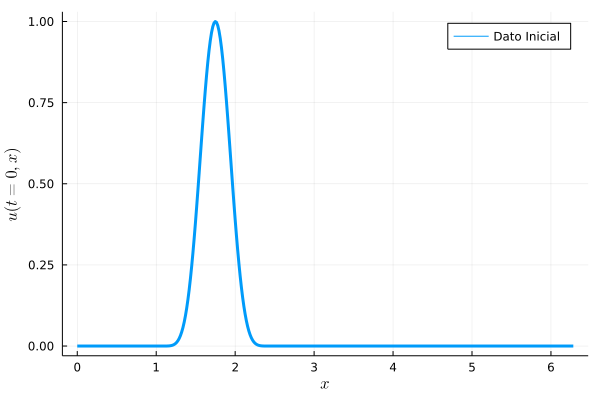

In [3]:
N = 400                                #Número de puntos
dx = 2*pi/(N-1)                        #Δx
x = [dx*(i-1) for i in 1:N]            #Discretización Espacial
u0 = zeros(N)                          #Vector del dato inicial
x0=1.0
x1=2.5
p=8
for i in 1:N
    if x[i] > x0 && x[i] < x1
        u0[i] = (x[i] - x0)^p * (x[i] - x1)^p / (0.5*(x1-x0))^(2p)
    end
end

plot(x,u0, label = "Dato Inicial",xlabel="\$x\$",ylabel="\$u(t=0,x)\$",lw=3)

Parámetros iniciales y operadores de diferencia finita para cumplir con SBP

In [4]:
c=1.0;   # velocidad de propagación
T=20.0; # tiempo final de evolución
ω=1.0;  # frecuencia de oscilación para definir condiciones de contorno
D4SBP=create_D4SBP(N);h4=h4!(N);

Resolvemos EDOS

In [15]:
dt=dx/c;
Nt=round(Int,T/dt);

u0_right = copy(u0);
u0_left = copy(u0);

sol_u = zero(Matrix{Float64}(undef,Nt,N));
sol_v = zero(Matrix{Float64}(undef,Nt,N));

sol_u[1,:] .= 0.5.*c.*(u0_right .- u0_left);
sol_v[1,:] .= 0.5.*(u0_left .+ u0_right);

t_evol = 0.0;
for i in 2:Nt

    c_right=c; # Velocidad de advección
    sol_minus=resolve_EDO_oneStep(D4SBP,h4[1,1],dx,t_evol,dt,c_right,F_sbp_matricial_right!,reflection,u0_left[1],u0_right,RK4);

    c_left=-c; # Velocidad de advección
    sol_plus=resolve_EDO_oneStep(D4SBP,h4[N,N],dx,t_evol,dt,c_left,F_sbp_matricial_left!,reflection,u0_right[N],u0_left,RK4);

    u0_right = sol_minus.u[:,1];sol_u[i,:] .= 0.5.*c.*(u0_right .- u0_left);
    sol_v[i,:] .= 0.5.*(u0_left .+ u0_right);
    u0_left = sol_plus.u[:,1];

    sol_u[i,:] .= 0.5.*c.*(u0_right .- u0_left);
    sol_v[i,:] .= 0.5.*(u0_left .+ u0_right);

    t_evol=sol_minus.t[end]
end

┌ Info: Saved animation to 
│   fn = /home/mendez/github_repositories/my_repositories/pde2022/tareas/03_tarea/plots/01_wave_equation_reflexion.gif
└ @ Plots /home/mendez/.julia/packages/Plots/lW9ll/src/animation.jl:137


Plots.AnimatedGif("/home/mendez/github_repositories/my_repositories/pde2022/tareas/03_tarea/plots/01_wave_equation_reflexion.gif")
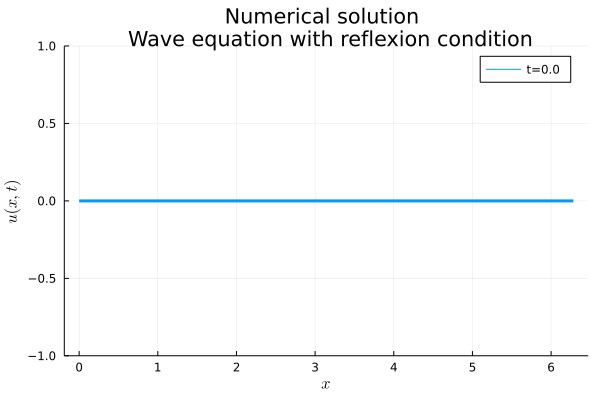

In [16]:
anim_01 = @animate for i in 1:4:Nt
    plot(x, sol_u[i,:], yaxis = ("\$u(x,t)\$", (-1.0,1.0)),
        xlabel = "\$x\$", label = "t=$(round((i*T/Nt); digits=1))",lw=3,
        title="Numerical solution \n Wave equation with reflexion condition")
end

# display(gif(anim_01,fps=30))
gif(anim_01,"../plots/01_wave_equation_reflexion.gif", fps = 30)

┌ Info: Saved animation to 
│   fn = /home/mendez/github_repositories/my_repositories/pde2022/tareas/03_tarea/plots/02_wave_equation_reflexion.gif
└ @ Plots /home/mendez/.julia/packages/Plots/lW9ll/src/animation.jl:137


Plots.AnimatedGif("/home/mendez/github_repositories/my_repositories/pde2022/tareas/03_tarea/plots/02_wave_equation_reflexion.gif")
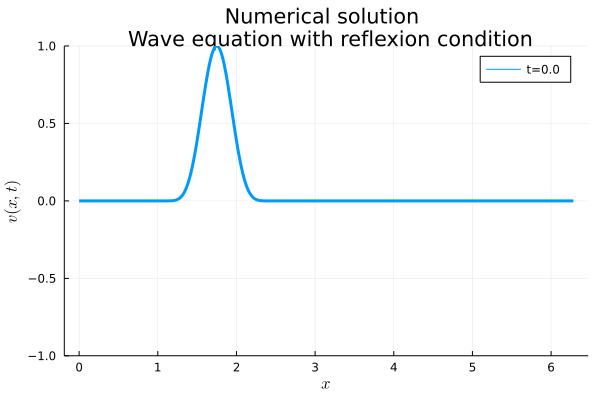

In [17]:
anim_02 = @animate for i in 1:4:Nt
    plot(x, sol_v[i,:], yaxis = ("\$v(x,t)\$", (-1.0,1.0)),
        xlabel = "\$x\$", label = "t=$(round((i*T/Nt); digits=1))",lw=3)
    plot!(title="Numerical solution \n Wave equation with reflexion condition")
end

# display(gif(anim_02,fps=30))
gif(anim_02, "../plots/02_wave_equation_reflexion.gif", fps = 30)

-----------------

**5)** **Para los intrépidos:** Considere dos regiones contiguas, $L_L$ y $L_R$ en ellas evolucionan una ecuación de onda pero con distintas velocidades $(c_L, c_R)$ (imagine que las regiones son cuerdas y están construidas de distintos medios o densidades). Trate la interfase entre los medios como un lugar donde uno da condiciones de contorno de acuerdo a lo que proviene de la otra región. Elija estas condiciones de manera que $\phi_t$ y $\phi_x$ sean continuas a través de la interfase. Implemente el código reflejando la situación descripta. Implemente condiciones de contorno en la parte izquierda de $L_L$ de forma que ingrese una onda sinusoidal. Implemente condiciones de contorno en la parte derecha de $L_R$ de forma que la onda saliente rebote y se convierta en entrante. 

-----------------

Un ejemplo a lo que debería llegar:
![Cuerdas](../plots/ropes_anim_fps20.gif)

In [4]:
include("../../../modules/module_advection_equation_finite_differences.jl")

resolve_EDO_oneStep2 (generic function with 1 method)

#### Dato inicial

In [18]:
c1=1.0      # velocidad de propagación en la regíon I
c2=3.0*c1   # velocidad de propagación en la región II

# ambas velocidades deben ser positivas

3.0

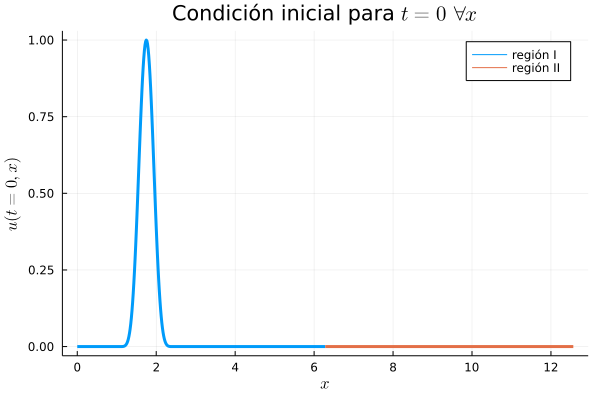

In [19]:
N = 400                          # Número de puntos por cada región
Δx = 2π/(N-1)                    # paso espacial
x1 = [Δx*(i-1) for i in 1:N]     # Vector espacial discreto region I  [0;2π]
x2 = [Δx*(i-1)+2π for i in 1:N]  # Vector espacial discreto region II [2π;4π]
u0_1 = zeros(N)                  # Vector del dato inicial región I
u0_2 = zeros(N)                  # Vector del dato inicial región II

# Proponemos polinomio suficientemente diferenciable y suave
#  para dato inicial en la región I.
a=1.0;b=2.5;p=8;
for i in 1:N
    if x1[i] > a && x1[i] < b
        u0_1[i] = (x1[i] - a)^p * (x1[i] - b)^p / (0.5*(a-b))^(2p)
    end
end

plot(x1,u0_1, label = "región I",xlabel="\$x\$",ylabel="\$u(t=0,x)\$",lw=3)
plot!(x2,u0_2, label = "región II",xlabel="\$x\$",ylabel="\$u(t=0,x)\$",lw=3)
plot!(title="Condición inicial para \$t=0\$ \$∀ x\$")

Parámetros iniciales y operadores de diferencia finita para cumplir con SBP

In [20]:
T=20.0; # tiempo final de evolución
ω=1.0;  # frecuencia de oscilación para definir condiciones de contorno
D4SBP=create_D4SBP(N);h4=h4!(N);

In [21]:
Δt_min=Δx/max(c1,c2);
Nt=round(Int,T/Δt_min);

u0_right_1 = copy(u0_1);
u0_left_1 = copy(u0_2);

u0_left_2 = copy(u0_2);
u0_right_2 = copy(u0_2);

sol_u1 = zero(Matrix{Float64}(undef,Nt,N));
sol_v1 = zero(Matrix{Float64}(undef,Nt,N));
sol_u2 = zero(Matrix{Float64}(undef,Nt,N));
sol_v2 = zero(Matrix{Float64}(undef,Nt,N));

sol_u1[1,:] .= 0.5.*c1.*(u0_right_1 .- u0_left_1);
sol_v1[1,:] .= 0.5.*(u0_left_1 .+ u0_right_1);

sol_u2[1,:] .= 0.5.*c2.*(u0_right_2 .- u0_left_2);
sol_v2[1,:] .= 0.5.*(u0_left_2 .+ u0_right_2);

time_evol=0.0

for i in 2:Nt

    # ecuación de advección viajando hacia la derecha (zona I)
    c_right_1=c1; # Velocidad de advección
    sol_minus_1=resolve_EDO_oneStep(D4SBP,h4[1,1],Δx,time_evol,Δt_min,c_right_1,F_sbp_matricial_right!,sine_squared_pulse_function,ω,u0_right_1,RK4);

    # ecuación de advección viajando hacia la izquierda (zona II)
    c_left_2=-c2; # Velocidad de advección
    sol_plus_2=resolve_EDO_oneStep(D4SBP,h4[N,N],Δx,time_evol,Δt_min,c_left_2,F_sbp_matricial_left!,reflection,u0_right_2[N],u0_left_2,RK4);

    # ecuación de advección viajando hacia la izquierda (zona I)
    c_left_1=-c1; # Velocidad de advección
    params1=(c1,c2,sol_minus_1.u[end,1],sol_plus_2.u[1,1]);
    sol_plus_1=resolve_EDO_oneStep(D4SBP,h4[N,N],Δx,time_evol,Δt_min,c_left_1,F_sbp_matricial_left!,refraction_left,params1,u0_left_1,RK4);
    
    # ecuación de advección viajando hacia la derecha (zona II)
    c_right_2=c2; # Velocidad de advección
    params2=(c1,c2,sol_minus_1.u[end,1],sol_plus_2.u[1,1]);
    sol_minus_2=resolve_EDO_oneStep(D4SBP,h4[1,1],Δx,time_evol,Δt_min,c_right_2,F_sbp_matricial_right!,refraction_right,params2,u0_right_2,RK4);

    u0_right_1 = sol_minus_1.u[:,1]; u0_right_2 = sol_minus_2.u[:,1];
    u0_left_1 = sol_plus_1.u[:,1]; u0_left_2 = sol_plus_2.u[:,1];

    sol_u1[i,:] .= 0.5.*c1.*(u0_right_1 .- u0_left_1);
    sol_v1[i,:] .= 0.5.*(u0_left_1 .+ u0_right_1);

    sol_u2[i,:] .= 0.5.*c2.*(u0_right_2 .- u0_left_2);
    sol_v2[i,:] .= 0.5.*(u0_left_2 .+ u0_right_2);

    time_evol = sol_minus_1.t[end]
end

┌ Info: Saved animation to 
│   fn = /home/mendez/github_repositories/my_repositories/pde2022/tareas/03_tarea/plots/01_wave_equation_medium.gif
└ @ Plots /home/mendez/.julia/packages/Plots/lW9ll/src/animation.jl:137


Plots.AnimatedGif("/home/mendez/github_repositories/my_repositories/pde2022/tareas/03_tarea/plots/01_wave_equation_medium.gif")
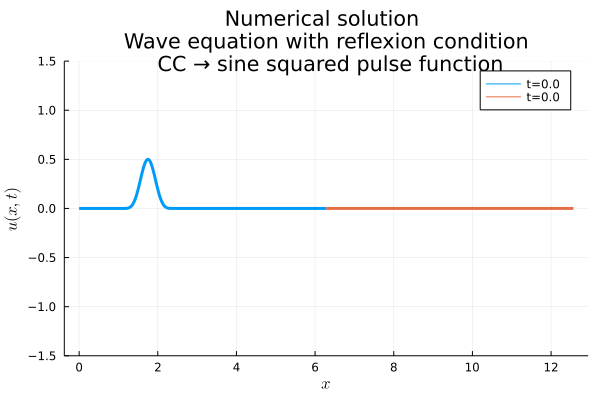

In [23]:
anim_01 = @animate for i in 1:10:Nt
    plot(x1, sol_u1[i,:], yaxis = ("\$u(x,t)\$", (-1.5,1.5)),
        xlabel = "\$x\$", label = "t=$(round((i*T/Nt); digits=1))",lw=3)
    plot!(x2, sol_u2[i,:], yaxis = ("\$u(x,t)\$", (-1.5,1.5)),
        xlabel = "\$x\$", label = "t=$(round((i*T/Nt); digits=1))",lw=3)
    plot!(title="Numerical solution \n Wave equation with reflexion condition \n CC → sine squared pulse function")
end

# display(gif(anim_01,fps=30))
gif(anim_01, "../plots/01_wave_equation_medium.gif", fps = 30)

In [24]:
Δtspecif=Δx/max(c1,c2);
Nt=round(Int,T/Δtspecif);

u0_right_1 = copy(u0_1);
u0_left_1 = copy(u0_2);

u0_left_2 = copy(u0_2);
u0_right_2 = copy(u0_2);

sol_u1 = zero(Matrix{Float64}(undef,Nt,N));
sol_v1 = zero(Matrix{Float64}(undef,Nt,N));
sol_u2 = zero(Matrix{Float64}(undef,Nt,N));
sol_v2 = zero(Matrix{Float64}(undef,Nt,N));

sol_u1[1,:] .= 0.5.*c1.*(u0_right_1 .- u0_left_1);
sol_v1[1,:] .= 0.5.*(u0_left_1 .+ u0_right_1);

sol_u2[1,:] .= 0.5.*c2.*(u0_right_2 .- u0_left_2);
sol_v2[1,:] .= 0.5.*(u0_left_2 .+ u0_right_2);

time_evol=0.0

for i in 2:Nt

    # ecuación de advección viajando hacia la derecha (zona I)
    c_right_1=c1; # Velocidad de advección
    sol_minus_1=resolve_EDO_oneStep(D4SBP,h4[1,1],Δx,time_evol,Δtspecif,c_right_1,F_sbp_matricial_right!,wave_modulation_function,ω,u0_right_1,RK4);

    # ecuación de advección viajando hacia la izquierda (zona II)
    c_left_2=-c2; # Velocidad de advección
    sol_plus_2=resolve_EDO_oneStep(D4SBP,h4[N,N],Δx,time_evol,Δtspecif,c_left_2,F_sbp_matricial_left!,reflection,u0_right_2[N],u0_left_2,RK4);

    # ecuación de advección viajando hacia la izquierda (zona I)
    c_left_1=-c1; # Velocidad de advección
    params1=(c1,c2,sol_minus_1.u[end,1],sol_plus_2.u[1,1]);
    sol_plus_1=resolve_EDO_oneStep(D4SBP,h4[N,N],Δx,time_evol,Δtspecif,c_left_1,F_sbp_matricial_left!,refraction_left,params1,u0_left_1,RK4);
    
    # ecuación de advección viajando hacia la derecha (zona II)
    c_right_2=c2; # Velocidad de advección
    params2=(c1,c2,sol_minus_1.u[end,1],sol_plus_2.u[1,1]);
    sol_minus_2=resolve_EDO_oneStep(D4SBP,h4[1,1],Δx,time_evol,Δtspecif,c_right_2,F_sbp_matricial_right!,refraction_right,params2,u0_right_2,RK4);

    u0_right_1 = sol_minus_1.u[:,1]; u0_right_2 = sol_minus_2.u[:,1];
    u0_left_1 = sol_plus_1.u[:,1]; u0_left_2 = sol_plus_2.u[:,1];

    sol_u1[i,:] .= 0.5.*c1.*(u0_right_1 .- u0_left_1);
    sol_v1[i,:] .= 0.5.*(u0_left_1 .+ u0_right_1);

    sol_u2[i,:] .= 0.5.*c2.*(u0_right_2 .- u0_left_2);
    sol_v2[i,:] .= 0.5.*(u0_left_2 .+ u0_right_2);

    time_evol = sol_minus_1.t[end]
end

┌ Info: Saved animation to 
│   fn = /home/mendez/github_repositories/my_repositories/pde2022/tareas/03_tarea/plots/02_wave_equation_medium.gif
└ @ Plots /home/mendez/.julia/packages/Plots/lW9ll/src/animation.jl:137


Plots.AnimatedGif("/home/mendez/github_repositories/my_repositories/pde2022/tareas/03_tarea/plots/02_wave_equation_medium.gif")
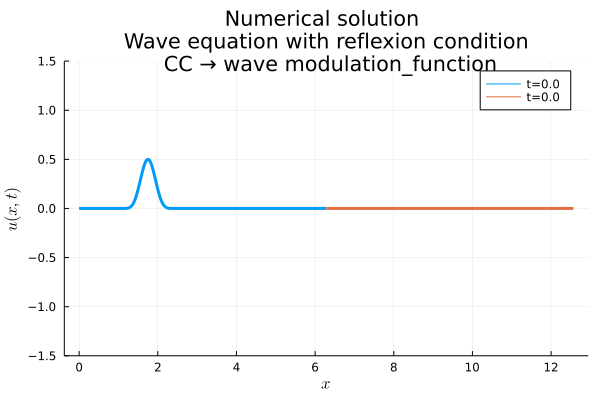

In [25]:
anim_02 = @animate for i in 1:10:Nt
    plot(x1, sol_u1[i,:], yaxis = ("\$u(x,t)\$", (-1.5,1.5)),
        xlabel = "\$x\$", label = "t=$(round((i*T/Nt); digits=1))",lw=3)
    plot!(x2, sol_u2[i,:], yaxis = ("\$u(x,t)\$", (-1.5,1.5)),
        xlabel = "\$x\$", label = "t=$(round((i*T/Nt); digits=1))",lw=3)
    plot!(title="Numerical solution \n Wave equation with reflexion condition \n CC → wave modulation_function")
end

# display(gif(anim_01,fps=30))
gif(anim_02, "../plots/02_wave_equation_medium.gif", fps = 30)

In [27]:
Δtspecif=Δx/max(c1,c2);
Nt=round(Int,T/Δtspecif);

u0_right_1 = copy(u0_1);
u0_left_1 = copy(u0_2);

u0_left_2 = copy(u0_2);
u0_right_2 = copy(u0_2);

sol_u1 = zero(Matrix{Float64}(undef,Nt,N));
sol_v1 = zero(Matrix{Float64}(undef,Nt,N));
sol_u2 = zero(Matrix{Float64}(undef,Nt,N));
sol_v2 = zero(Matrix{Float64}(undef,Nt,N));

sol_u1[1,:] .= 0.5.*c1.*(u0_right_1 .- u0_left_1);
sol_v1[1,:] .= 0.5.*(u0_left_1 .+ u0_right_1);

sol_u2[1,:] .= 0.5.*c2.*(u0_right_2 .- u0_left_2);
sol_v2[1,:] .= 0.5.*(u0_left_2 .+ u0_right_2);

time_evol=0.0 # seteamos en cero el tiempo evolucionado

for i in 2:Nt

    # ecuación de advección viajando hacia la derecha (zona I)
    c_right_1=c1; # Velocidad de advección
    sol_minus_1=resolve_EDO_oneStep(D4SBP,h4[1,1],Δx,time_evol,Δtspecif,c_right_1,F_sbp_matricial_right!,step_function,ω,u0_right_1,RK4);

    # ecuación de advección viajando hacia la izquierda (zona II)
    c_left_2=-c2; # Velocidad de advección
    sol_plus_2=resolve_EDO_oneStep(D4SBP,h4[N,N],Δx,time_evol,Δtspecif,c_left_2,F_sbp_matricial_left!,reflection,u0_right_2[N],u0_left_2,RK4);

    # ecuación de advección viajando hacia la izquierda (zona I)
    c_left_1=-c1; # Velocidad de advección
    params1=(c1,c2,sol_minus_1.u[end,1],sol_plus_2.u[1,1]);
    sol_plus_1=resolve_EDO_oneStep(D4SBP,h4[N,N],Δx,time_evol,Δtspecif,c_left_1,F_sbp_matricial_left!,refraction_left,params1,u0_left_1,RK4);
    
    # ecuación de advección viajando hacia la derecha (zona II)
    c_right_2=c2; # Velocidad de advección
    params2=(c1,c2,sol_minus_1.u[end,1],sol_plus_2.u[1,1]);
    sol_minus_2=resolve_EDO_oneStep(D4SBP,h4[1,1],Δx,time_evol,Δtspecif,c_right_2,F_sbp_matricial_right!,refraction_right,params2,u0_right_2,RK4);

    u0_right_1 = sol_minus_1.u[:,1]; u0_right_2 = sol_minus_2.u[:,1];
    u0_left_1 = sol_plus_1.u[:,1]; u0_left_2 = sol_plus_2.u[:,1];

    sol_u1[i,:] .= 0.5.*c1.*(u0_right_1 .- u0_left_1);
    sol_v1[i,:] .= 0.5.*(u0_left_1 .+ u0_right_1);

    sol_u2[i,:] .= 0.5.*c2.*(u0_right_2 .- u0_left_2);
    sol_v2[i,:] .= 0.5.*(u0_left_2 .+ u0_right_2);

    time_evol = sol_minus_1.t[end] # aumentamos en un paso el tiempo evolucionado
end

┌ Info: Saved animation to 
│   fn = /home/mendez/github_repositories/my_repositories/pde2022/tareas/03_tarea/plots/03_wave_equation_medium.gif
└ @ Plots /home/mendez/.julia/packages/Plots/lW9ll/src/animation.jl:137


Plots.AnimatedGif("/home/mendez/github_repositories/my_repositories/pde2022/tareas/03_tarea/plots/03_wave_equation_medium.gif")
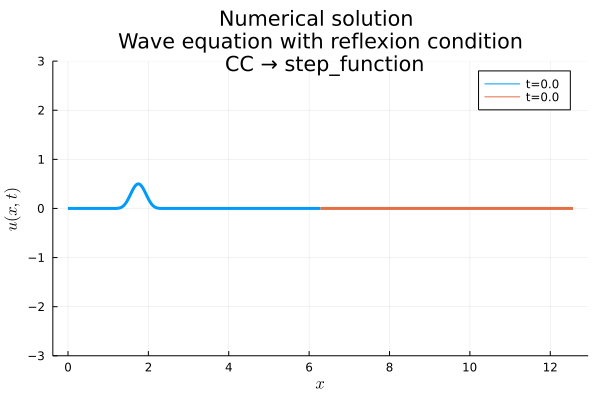

In [29]:
anim_03 = @animate for i in 1:10:Nt
    plot(x1, sol_u1[i,:], yaxis = ("\$u(x,t)\$", (-3.0,3.0)),
        xlabel = "\$x\$", label = "t=$(round((i*T/Nt); digits=1))",lw=3)
    plot!(x2, sol_u2[i,:], yaxis = ("\$u(x,t)\$", (-3.0,3.0)),
        xlabel = "\$x\$", label = "t=$(round((i*T/Nt); digits=1))",lw=3)
    plot!(title="Numerical solution \n Wave equation with reflexion condition \n CC → step_function")
end

# display(gif(anim_01,fps=30))
gif(anim_03, "../plots/03_wave_equation_medium.gif", fps = 30)